In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import sympy as sp
from scipy.interpolate import RegularGridInterpolator

x, y = sp.symbols('x,y')
ue = x*(1-x)*y*(1-y)*sp.exp(sp.cos(4*sp.pi*x)*sp.sin(2*sp.pi*y))
f = ue.diff(x, 2) + ue.diff(y, 2)

In [2]:
#copied fom lecture 6
def D2(N):
    D = sparse.diags([1, -2, 1], [-1, 0, 1], (N+1, N+1), 'lil')
    D[0, :4] = 2, -5, 4, -1
    D[-1, -4:] = -1, 4, -5, 2
    return D
def laplace(dx, dy, N):
    D2x = (1./dx**2)*D2(N)
    D2y = (1./dy**2)*D2(N)
    return (sparse.kron(D2x, sparse.eye(N+1)) + 
            sparse.kron(sparse.eye(N+1), D2y))
def mesh2D(N,L):
    x = np.linspace(0, L, N+1)
    y = np.linspace(0, L, N+1)
    return np.meshgrid(x, y, indexing='ij')
N = 100
L = 1
xij, yij = mesh2D(N,L)
F = sp.lambdify((x, y), f)(xij, yij)
A = laplace(L/N,L/N, N)
B = np.ones((N+1, N+1), dtype=bool)
B[1:-1, 1:-1] = 0
bnds = np.where(B.ravel() == 1)[0]
A = A.tolil()
for i in bnds:
    A[i] = 0
    A[i, i] = 1
A = A.tocsr()
b = F.ravel()
b[bnds] = 0
U = sparse.linalg.spsolve(A, b)
U = np.reshape(U, (N+1, N+1))
U.shape

(101, 101)

In [3]:
def eval(x_arg, y_arg):
    x_indices = np.linspace(0, L, N+1)
    y_indices = np.linspace(0, L, N+1)
    interpolator = RegularGridInterpolator((x_indices, y_indices), U, method='linear', bounds_error=False, fill_value=None)
    interpolated_value = interpolator((x_arg, y_arg))
    return interpolated_value

array(0.02869633)

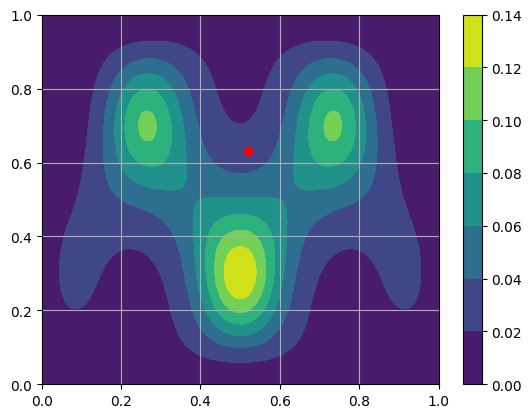

In [4]:
test_x = 0.5
test_y=0.6
test_x = 0.52
test_y=0.63
#print(sol.eval(0.52, 0.63))
plt.contourf(xij, yij, U);
plt.colorbar()
plt.scatter(test_x, test_y, color='red', label='Point')
plt.grid()
eval(test_x, test_y) 

In [5]:
# will not work for coarser grid because of not enough presion, eg N = 10, remember to set N=100
assert abs(eval(0.52, 0.63) - ue.subs({x: 0.52, y: 0.63}).n()) < 1e-3

In [6]:
h = L/N
h, h/2
eval(h/2, 1-h/2)

array(2.2979317e-05)

In [7]:
ue.subs({x: h, y: 1-h/2}).n()

4.77413095729255e-5

In [8]:
diff = abs(eval(h/2, 1-h/2) - ue.subs({x: h, y: 1-h/2}).n())
diff

2.47619926024630e-5

In [9]:
assert abs(eval(h/2, 1-h/2) - ue.subs({x: h, y: 1-h/2}).n())

In [10]:
# all possible points 
points = np.column_stack((xij.ravel(), yij.ravel()))
len(points)

10201

In [11]:
points

array([[0.  , 0.  ],
       [0.  , 0.01],
       [0.  , 0.02],
       ...,
       [1.  , 0.98],
       [1.  , 0.99],
       [1.  , 1.  ]])

In [12]:
points[0][0], points[0][1]

(0.0, 0.0)

In [13]:
errors = np.empty(len(points))
for i in range (0,len(points)):
    #points[i][0] is x, and points[i][1] is y
    errors[i] = abs(eval(points[i][0],  points[i][1]) - ue.subs({x: points[i][0], y: points[i][1]}).n()) 

In [14]:
errors

array([0., 0., 0., ..., 0., 0., 0.])

In [15]:
np.min(errors), np.max(errors)

(0.0, 0.0001766659638149093)

In [16]:
from scipy.stats import describe
describe(errors)

DescribeResult(nobs=10201, minmax=(0.0, 0.0001766659638149093), mean=2.242496882905557e-05, variance=6.429586925773381e-10, skewness=2.5975645787772432, kurtosis=8.398150075276028)